# Proyecto minería de datos


El proyecto tendrá como objetivo la clasificación de las emociones. Este análisis se hará con la base de datos de [RAVDESS](https://zenodo.org/record/1188976#.XsyEAmhKhPY). La cual tiene dos tipos de archivos:

Audio: Habla y canto
Video: Habla y canto
Cada uno de estos tiene varios identificadores, los cuales son los siguientes:

*   Modalidad (01 = full-AV, 02 = video-only, 03 = audio-only).

*   Canal de audio (01 = speech, 02 = song).
*   Emoción (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
*   Intensidad Emocional (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
*   Declaración (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
*   Repetición (01 = 1st repetition, 02 = 2nd repetition).
*   Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).


A través de esto, se busca realizar una clasificación de la emoción que encontramos en los archivos. Lo cual será desarrollado por medio de redes neuronales convolucionadas y redes LSTM.

Se tomará como referencia los siguientes proyectos:
Códigos tomados de: https://www.kaggle.com/bhavikjain/cnn-lstm/data
 https://github.com/marcogdepinto/Emotion-Classification-Ravdess/blob/master/EmotionsRecognition.ipynb



# Análisis de sentimientos en audios

El análisis de audio es acerca de analizar y comprender las señales capturadas por dispositivos digitales acerca del análisis y entendimientos de señales de audio. Se realizará un análisis de sentimientos para los audios, utilizando dos métodos diferentes:


*   Analizando directamente el audio a través de librosa y redes convolucionadas y redes LSTM.
*   Analizando el espectrograma del audio como una imagen a través de visión artificial por medio de CNN también. 

Para esto, primero se determinará las librerarías que serán usadadas a lo largo del documento


# Librerias en uso

In [0]:
import librosa
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import os #para interactuar con las carpetas y archivos
import pandas as pd
import librosa.display
import tensorflow as tf
import matplotlib.pyplot as plt
import joblib
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from tensorflow.keras.optimizers import Adam, SGD
from scipy.stats import zscore


# Conectar con drive para leer los datos desde allí 


In [14]:
from google.colab import drive #Conexión con Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#Ubicación de los datos 
#PATH = '/content/drive/My Drive/Minería de datos/Proyecto Minería de datos/data/Audio'
PATH = '/content/drive/My Drive/Estadistica/Estadistica/Mineria de datos/Proyecto Minería de datos/data/Audio/'
#PATH = 'G:\Mi unidad\Estadistica\Estadistica\Mineria de datos\Proyecto Minería de datos\data\Audio'

In [0]:
dic  =  {0:'neutral', 1:'calm', 2:'happy', 3:'sad', 4:'angry', 5:'fear', 6:'disgust', 7:'surprise'}

Se determinó a través del camino de la carpeta los archivos que encontramos en el objeto ``dir_list``, el cual tendrá los 2452 archivos de audio. 

In [18]:
dir_list = os.listdir(PATH)
dir_list.sort()
dir_list

['03-01-01-01-01-01-01.wav',
 '03-01-01-01-01-01-02.wav',
 '03-01-01-01-01-01-03.wav',
 '03-01-01-01-01-01-04.wav',
 '03-01-01-01-01-01-05.wav',
 '03-01-01-01-01-01-06.wav',
 '03-01-01-01-01-01-07.wav',
 '03-01-01-01-01-01-08.wav',
 '03-01-01-01-01-01-09.wav',
 '03-01-01-01-01-01-10.wav',
 '03-01-01-01-01-01-11.wav',
 '03-01-01-01-01-01-12.wav',
 '03-01-01-01-01-01-13.wav',
 '03-01-01-01-01-01-14.wav',
 '03-01-01-01-01-01-15.wav',
 '03-01-01-01-01-01-16.wav',
 '03-01-01-01-01-01-17.wav',
 '03-01-01-01-01-01-18.wav',
 '03-01-01-01-01-01-19.wav',
 '03-01-01-01-01-01-20.wav',
 '03-01-01-01-01-01-21.wav',
 '03-01-01-01-01-01-22.wav',
 '03-01-01-01-01-01-23.wav',
 '03-01-01-01-01-01-24.wav',
 '03-01-01-01-01-02-01.wav',
 '03-01-01-01-01-02-02.wav',
 '03-01-01-01-01-02-03.wav',
 '03-01-01-01-01-02-04.wav',
 '03-01-01-01-01-02-05.wav',
 '03-01-01-01-01-02-06.wav',
 '03-01-01-01-01-02-07.wav',
 '03-01-01-01-01-02-08.wav',
 '03-01-01-01-01-02-09.wav',
 '03-01-01-01-01-02-10.wav',
 '03-01-01-01-

In [19]:
dir_list[1].split('.')[0].split('-')[2]

'01'

Se crean dos objetos ``emotion`` y ``path``, donde en el primero se indicará qué tipo de emoción tenía al hablar donde:
*  01=Neutral
*  02=Calmado
*  03=Feliz
*  04=Triste
*  05=Enojado
*  06=Asustado
*  07=Disgustado
*  08= Sorprendido

Estos fueron extraídos de la **3ra posición** en el nombre del archivo:


In [0]:
emotion = []
mod = []
path = []

for f in dir_list:
  part1 = f.split('.')[0].split('-')[2]
  part2 = f.split('.')[0].split('-')[1]
  path.append(PATH +'/' + f)
  emotion.append(part1)
  mod.append(part2)



In [0]:
# filter rows for year 2002 using  the boolean expression
cam=np.array([path, mod, emotion])
cam=cam.transpose()

data=pd.DataFrame(cam, columns = ['path','mod', 'emotion'])
#


In [0]:
n=data[data['mod']=='02']

In [28]:
n.shape

(1012, 3)

Se puede notar que la cantidad de personas para cada uno de los tipos de emociones no es la misma, donde para la emoción neutral tenemos la mitad que para las emociones. Mientras que para las emociones de disgusto y sorprsa tenemos un poco más de la mitad que para las de calma, felicidad, tristeza, enojado y asustado. 


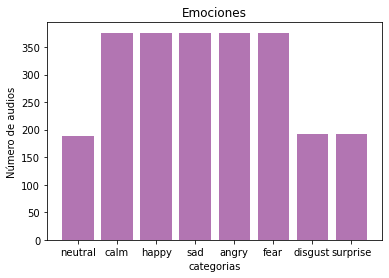

In [0]:

# Make a fake dataset:
height = pd.DataFrame(emotion).groupby(emotion).size()
bars = ('neutral','calm','happy', 'sad', 'angry','fear', 'disgust','surprise')
y_pos = np.arange(len(bars))
 
# Create bars
plt.bar(y_pos, height, color = (0.5,0.1,0.5,0.6))
 
# Add title and axis names
plt.title('Emociones')
plt.xlabel('categorias')
plt.ylabel('Número de audios')

# Create names on the x-axis
plt.xticks(y_pos, bars)


# Show graphic
plt.show()


Ahora, a través de la librería librosa se leerá cada uno de los audios. Para esto se determinará lo siguiente: 
* X: Serie de tiempo del audio
* sample_rate: Frecuencia de muestreo de y
* mfcss: Coeficientes cepstrales de frecuencia de mel (MFCC)

En el procesamiento de señales, el sampling es la reducción de una señal continua en una serie de valores discretos. La **rate** o **sampling frecuency** es el número de muestras tomadas durante un período de tiempo fijo. Una alta frecuencia de muestreo da como resultado una menor pérdida de información pero un mayor gasto computacional, y las bajas frecuencias de muestreo tienen una mayor pérdida de información pero son rápidas y baratas de calcular.

Los coeficientes cepstrales de frecuencia Mel (MFCC) de una señal son un pequeño conjunto de características (generalmente alrededor de 10-20) que describen de manera concisa la forma general de una envoltura espectral. Modela las características de la voz humana.

MFCCs se calculan comúnmente de la siguiente forma:

  1. Separar la señal en pequeños tramos.
  2. A cada tramo aplicarle la Transformada de Fourier discreta y obtener la potencia espectral de la señal.
  3. Aplicar el banco de filtros correspondientes a la Escala Mel al espectro obtenido en el paso anterior y sumar las energías en cada uno de ellos.
  4. Tomar el logaritmo de todas las energías de cada frecuencia mel
  5. Aplicarle la transformada de coseno discreta a estos logaritmos.
  6. Estos valores obtenidos son los coeficientes que buscamos. Aunque opcionalmente se le pueden añadir otros valores como los deltas y/o los delta-deltas.


A través de las características se leen los datos y tendremos las tres características nombradas anteriormente. 


In [0]:
signal = []

# Sample rate (16.0 kHz)
sample_rate = 16000     

# Max pad lenght (3.0 sec)
max_pad_len = 49100

for index,path in enumerate(RAV_df.path):
    X, sample_rate = librosa.load(path
                                  ,duration=3
                                  ,offset=0.5
                                 )
    sample_rate = np.array(sample_rate)
    
    y = zscore(X)
        
    # Padding or truncated signal 
    if len(y) < max_pad_len:    
        y_padded = np.zeros(max_pad_len)
        y_padded[:len(y)] = y
        y = y_padded
    elif len(y) > max_pad_len:
        y = np.asarray(y[:max_pad_len])

    # Add to signal list
    signal.append(y)
    

In [0]:
import time
lst = []
start_time = time.time()

for p in dir_list:
    X, sample_rate = librosa.load(PATH + '/' + p, res_type='kaiser_fast')
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
    arr=mfccs, p
    lst.append(arr)


print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))


KeyboardInterrupt: ignored

Luego, a partir de nuestros resultados de MFCC, creamos un array con los calores del MFCC y con el path de cada uno de estos archivos

In [0]:
# Creating X and y: zip makes a list of all the first elements, and a list of all the second elements.
X, y1 = zip(*lst)

In [0]:
numbers = [ int(x)-1 for x in emotion ]
print(numbers)
y=numbers

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

Luego, tomaremos como nuestro y la resuesta de 1 hasta 8 para poder realizar la clasificación mediante redes neuronales. Por lo tanto creamos dos array de numpy con esta información.  Como se puede observar el tamaño X como resultado del MFCC será de 2452 x 40 y  nuestra respuesta y, será de 2452.

In [0]:
import numpy as np
X = np.asarray(X)
y = np.asarray(y)

X.shape, y.shape

NameError: ignored

In [0]:
mod=np.asarray(mod)

Como la lectura de los datos se demora mucho tiempo, se guardaran los vectores X y y por medio de la librería joblib y el método dump, de esta forma, luego se podrá leer estos datos en vez de realizar de nuevo el procedimiento de librosa para leer y especificar su MFCC

In [0]:
# Saving joblib files to not load them again with the loop above
#X_name = 'X.joblib'
#y_name = 'y.joblib'
mod_name='mod.joblib'
save_dir = '/content/drive/My Drive/Estadistica/Estadistica/Mineria de datos/Proyecto Minería de datos/Model_audio'

#savedX = joblib.dump(X, os.path.join(save_dir, X_name))
#savedy = joblib.dump(y, os.path.join(save_dir, y_name))
savedmod = joblib.dump(mod, os.path.join(save_dir, mod_name))


Por medio del método load de joblib se podrá leer los archivos previamente guardados en la carpeta. 

In [0]:
# Loading saved models
import joblib

X = joblib.load('G:\Mi unidad\Estadistica\Estadistica\Mineria de datos\Proyecto Minería de datos\Model_audio\X.joblib')
y = joblib.load('G:\Mi unidad\Estadistica\Estadistica\Mineria de datos\Proyecto Minería de datos\Model_audio\y.joblib')

# Red neuronal 


In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [0]:
x_traincnn = tf.convert_to_tensor(np.expand_dims(X_train, axis=2))
x_testcnn = tf.convert_to_tensor(np.expand_dims(X_test, axis=2))
y_train=tf.convert_to_tensor(y_train)
y_test=tf.convert_to_tensor(y_test)
#x_traincnn = (np.expand_dims(X_train, axis=2))
#x_testcnn = (np.expand_dims(X_test, axis=2))#

#y_train=(y_train)
#y_test=(y_test)


In [0]:
x_traincnn.shape, x_testcnn.shape

(TensorShape([1961, 40, 1]), TensorShape([491, 40, 1]))

In [0]:
print(np.flatnonzero(np.equal(x_traincnn, None)))
print(np.flatnonzero(np.equal(x_testcnn, None)))
print(np.flatnonzero(np.equal(y_test, None)))
print(np.flatnonzero(np.equal(y_train, None)))

[]
[]
[]
[]


In [0]:
print(np.isnan(x_traincnn).sum())
print(np.isnan(x_testcnn).sum())
#np.isnan(y_test).sum()
#np.isnan(y_train).sum()

0
0


In [0]:
model = Sequential()
model.add(Conv1D(128, 5,padding='same', input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))


#### Otra opción de Red Neuronal con LSTM y CNN es
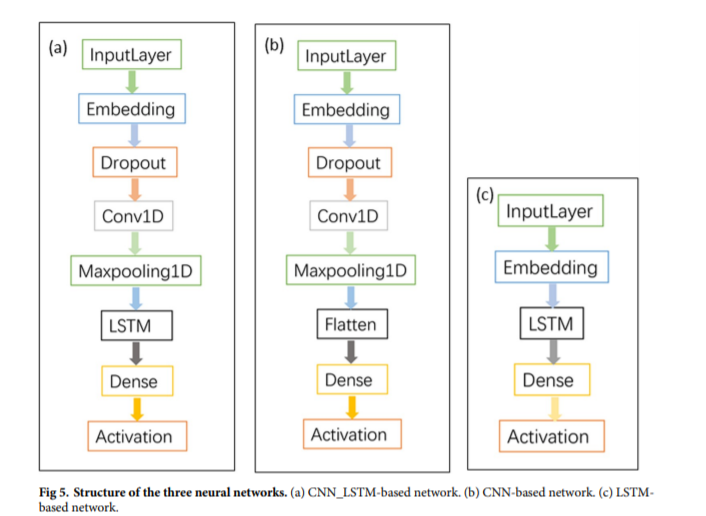

In [0]:
model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 40, 128)           768       
_________________________________________________________________
activation_10 (Activation)   (None, 40, 128)           0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 5, 128)            82048     
_________________________________________________________________
activation_11 (Activation)   (None, 5, 128)            0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 5, 128)           

In [0]:
opt = keras.optimizers.rmsprop(lr=0.00005, rho=0.9, decay=0.0)
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=opt,
              metrics=['accuracy'])
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape
len(x_testcnn)

491

In [0]:
cnnhistory=model.fit(x_traincnn, y_train,  epochs=100, validation_data=(x_testcnn, y_test), steps_per_epoch=round(len(x_traincnn)/15), validation_steps=round(len(x_testcnn)/15))

Train on 1961 samples, validate on 491 samples
Epoch 1/100
131/131 [==============================] - 52s 397ms/step - loss: 0.4451 - accuracy: 0.0730 - val_loss: 0.0372 - val_accuracy: 0.0000e+00
Epoch 2/100
131/131 [==============================] - 52s 399ms/step - loss: 0.4371 - accuracy: 0.0733 - val_loss: 0.0374 - val_accuracy: 0.0000e+00
Epoch 3/100
131/131 [==============================] - 52s 397ms/step - loss: 0.4303 - accuracy: 0.0736 - val_loss: 0.0376 - val_accuracy: 0.0000e+00
Epoch 4/100
131/131 [==============================] - 53s 402ms/step - loss: 0.4224 - accuracy: 0.0732 - val_loss: 0.0376 - val_accuracy: 0.0000e+00
Epoch 5/100
131/131 [==============================] - 52s 397ms/step - loss: 0.4143 - accuracy: 0.0738 - val_loss: 0.0376 - val_accuracy: 0.0000e+00
Epoch 6/100
131/131 [==============================] - 53s 401ms/step - loss: 0.4063 - accuracy: 0.0742 - val_loss: 0.0377 - val_accuracy: 0.0000e+00
Epoch 7/100
131/131 [==============================] 

In [0]:
#model = Sequential()
#model.add(Flatten())
#model.add(Dense(256, activation='relu', input_shape=(x_traincnn.shape[1],)))
#model.add(Dense(128, activation='relu'))
#model.add(Dense(64, activation='relu'))
#model.add(Dense(10, activation='softmax'))
#model.compile(optimizer='adam',
#              loss='sparse_categorical_crossentropy',
#              metrics=['accuracy'])

In [0]:
#classifier = model.fit(x_traincnn,
#                    y_train,
#                    epochs=100,
#                    batch_size=128)

ValueError: ignored

#Random Forest


In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
rforest = RandomForestClassifier(criterion="gini", max_depth=10, max_features="log2", 
                                 max_leaf_nodes = 100, min_samples_leaf = 3, min_samples_split = 20, 
                                 n_estimators= 22000, random_state= 5)

In [0]:
rforest.fit(X_train, y_train)

KeyboardInterrupt: ignored

In [0]:
predictions = rforest.predict(X_test)

In [0]:
print(classification_report(y_test,predictions))

# CNN con la imagen del espectrograma


In [0]:
pip install memory_profiler

  Created wheel for memory-profiler: filename=memory_profiler-0.57.0-cp36-none-any.whl size=28992 sha256=5eca56cda6d5d27b412742f05d1887ba6531bc5c375579af6267a254472f0c27
  Stored in directory: /root/.cache/pip/wheels/74/20/b5/20964ef97be73d2c3a695c9cad7bccd96d1e3e737a8163861f
Successfully built memory-profiler


In [0]:
pip install path

In [0]:
%matplotlib inline
import os
import pandas as pd
from glob import glob
import numpy as np

from keras import layers
from keras import models
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
import keras.backend as K
import librosa
import librosa.display
import pylab
import matplotlib.pyplot as plt
from matplotlib import figure
import gc


In [0]:
def create_spectrogram(filename,name):
    plt.interactive(False)
    clip, sample_rate = librosa.load(filename, sr=None)
    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    S = librosa.feature.melspectrogram(y=clip, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    filename  = '/content/drive/My Drive/Estadistica/Estadistica/Mineria de datos/Proyecto Minería de datos/data/train/' + name + '.jpg'
    plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
    plt.close()    
    fig.clf()
    plt.close(fig)
    plt.close('all')
    del filename,name,clip,sample_rate,fig,ax,S

In [0]:
i=0
for file in path:
    #Define the filename as is, "name" refers to the JPG, and is split off into the number itself. 
    filename,name = file,file.split('/')[-1].split('.')[0]
    create_spectrogram(filename,name)
gc.collect()
#%%memit 
##i=2000
#for file in Data_dir[i:i+2000]:
#    filename,name = file,file.split('/')[-1].split('.')[0]
#    create_spectrogram(filename,name)
#gc.collect()
#%%memit 
#i=4000
#for file in Data_dir[i:]:
#    filename,name = file,file.split('/')[-1].split('.')[0]
#    create_spectrogram(filename,name)
#gc.collect()

6744

In [0]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from numpy import expand_dims
from tensorflow.keras.applications.vgg16 import preprocess_input

In [29]:
PATH = '/content/drive/My Drive/Estadistica/Estadistica/Mineria de datos/Proyecto Minería de datos/data/Audio Img/'
dir_list = os.listdir(PATH)
dir_list.sort()
len(dir_list)

2452

In [0]:
emotion = []
path = []
mod=[]

for f in dir_list:
  part1 = f.split('.')[0].split('-')[2]
  part2 = f.split('.')[0].split('-')[1]
  path.append(PATH +'/' + f)
  emotion.append(part1)
  mod.append(part2)


In [35]:
mod

['01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',
 '01',

In [0]:
img=[]
for file in path:
    img1 = load_img(file, target_size=(223, 217))
    img1 = img_to_array(img1)
    # expand dimensions so that it represents a single 'sample'
    img1 = expand_dims(img1, axis=0)
    # prepare the image (e.g. scale pixel values for the vgg)
    img1 = preprocess_input(img1)
    img.append(img1)
  

ImportError: Could not import PIL.Image. The use of `load_img` requires PIL.

In [0]:
n=np.array(img)
len(emotion)
n.size

NameError: ignored

In [0]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical


In [0]:
encoder=LabelEncoder()


In [0]:
# Saving joblib files to not load them again with the loop above
#X_name = 'X.joblib'
y_name = 'y.joblib'
mod_name = 'mod.joblib'

save_dir = '/content/drive/My Drive/Estadistica/Estadistica/Mineria de datos/Proyecto Minería de datos/Model_audio_img'

#savedX = joblib.dump(n, os.path.join(save_dir, X_name))
savedy = joblib.dump(emotion, os.path.join(save_dir, y_name))
savedmod = joblib.dump(mod, os.path.join(save_dir, mod_name))

In [0]:
# Loading saved models
import joblib

X = joblib.load('/content/drive/My Drive/Estadistica/Estadistica/Mineria de datos/Proyecto Minería de datos/Model_audio_img/X.joblib')
y = joblib.load('/content/drive/My Drive/Estadistica/Estadistica/Mineria de datos/Proyecto Minería de datos/Model_audio_img/y.joblib')
mod = joblib.load('/content/drive/My Drive/Estadistica/Estadistica/Mineria de datos/Proyecto Minería de datos/Model_audio_img/mod.joblib')

In [0]:
#encoder=LabelEncoder()

X1=X[:, 0, :, :]
X1.shape
#y=encoder.fit_transform(y)#Scaling the Feature columns
#y

(2452, 223, 217, 3)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)

In [0]:
#Keras
import keras
import warnings
warnings.filterwarnings('ignore')
from keras import layers
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add
from keras.models import Sequential
from keras.optimizers import SGD

In [0]:
model = Sequential()
input_shape=(223, 217, 3)
#1st hidden layer
model.add(Conv2D(32, (3, 3), strides=(2, 2), input_shape=input_shape))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))
#2nd hidden layer
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))
#3rd hidden layer
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))
#Flatten
model.add(Flatten())
model.add(Dropout(rate=0.5))
#Add fully connected layer.
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))
#Output layer
model.add(Dense(8))
model.add(Activation('softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 111, 108, 32)      896       
_________________________________________________________________
average_pooling2d_13 (Averag (None, 55, 54, 32)        0         
_________________________________________________________________
activation_21 (Activation)   (None, 55, 54, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 55, 54, 64)        18496     
_________________________________________________________________
average_pooling2d_14 (Averag (None, 27, 27, 64)        0         
_________________________________________________________________
activation_22 (Activation)   (None, 27, 27, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 27, 27, 64)       

In [0]:
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

In [0]:
y_train

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [0]:
epochs = 200
batch_size = 8
learning_rate = 0.01
decay_rate = learning_rate / epochs
momentum = 0.9
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
model.compile(optimizer="sgd", loss="categorical_crossentropy", metrics=['accuracy'])


In [0]:
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


Train on 1961 samples, validate on 491 samples
Epoch 1/10
1961/1961 [==============================] - 42s 21ms/step - loss: 2.0637 - accuracy: 0.1576 - val_loss: 2.0621 - val_accuracy: 0.1365
Epoch 2/10
1961/1961 [==============================] - 41s 21ms/step - loss: 2.0602 - accuracy: 0.1576 - val_loss: 2.0585 - val_accuracy: 0.1365
Epoch 3/10
1961/1961 [==============================] - 41s 21ms/step - loss: 2.0566 - accuracy: 0.1576 - val_loss: 2.0555 - val_accuracy: 0.1365
Epoch 4/10
1961/1961 [==============================] - 41s 21ms/step - loss: 2.0537 - accuracy: 0.1576 - val_loss: 2.0529 - val_accuracy: 0.1365
Epoch 5/10
1961/1961 [==============================] - 41s 21ms/step - loss: 2.0510 - accuracy: 0.1571 - val_loss: 2.0506 - val_accuracy: 0.1365
Epoch 6/10
1961/1961 [==============================] - 41s 21ms/step - loss: 2.0491 - accuracy: 0.1576 - val_loss: 2.0486 - val_accuracy: 0.1365
Epoch 7/10
1961/1961 [==============================] - 40s 21ms/step - loss:

In [0]:
fit=cnn3.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=15)

Train on 1961 samples, validate on 491 samples
Epoch 1/10
1961/1961 [==============================] - 240s 122ms/step - loss: 45.4390 - accuracy: 0.1617 - val_loss: 2.2173 - val_accuracy: 0.1202
Epoch 2/10
1961/1961 [==============================] - 240s 122ms/step - loss: 2.1385 - accuracy: 0.1555 - val_loss: 2.1072 - val_accuracy: 0.1202
Epoch 3/10
 720/1961 [==========>...................] - ETA: 2:24 - loss: 2.0739 - accuracy: 0.1583

KeyboardInterrupt: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


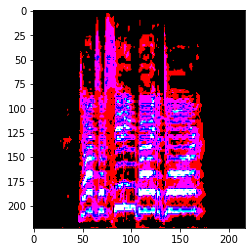

In [0]:
plt.figure()
plt.imshow(X_train[4])
plt.grid(False)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

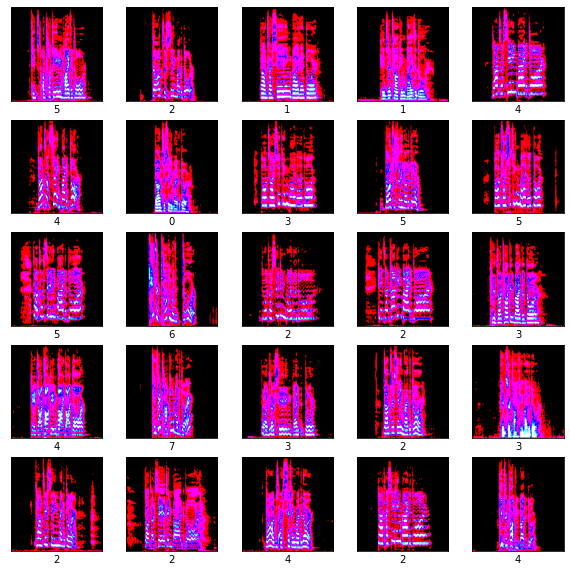

In [0]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2)

In [0]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(223, 217, 3)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
scores = model.evaluate(X_test,
                        y_test,
                        batch_size=batch_size,
                        verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 289.6066020025498
Test accuracy: 0.637474536895752


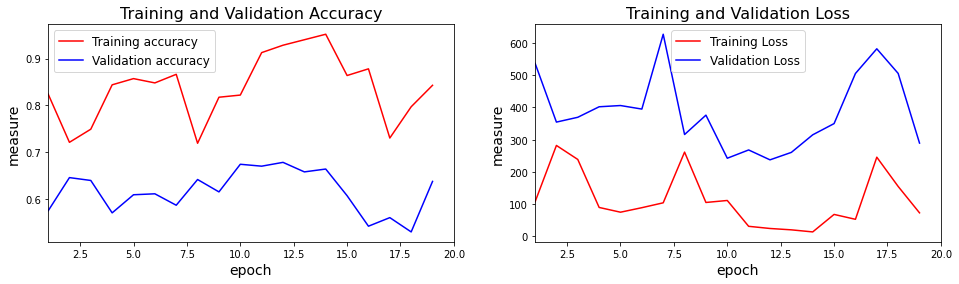

In [0]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

n_row = 1
n_col = 2
fig, ax = plt.subplots(n_row, n_col, sharex = False, sharey = False, figsize=(16,4))


ax[0].plot(epochs, acc, 'r', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
ax[0].legend(fontsize=12,loc=0)
ax[0].set_title('Training and Validation Accuracy',fontsize=16)
ax[0].set_ylabel('measure',fontsize=14)
ax[0].set_xlabel('epoch', fontsize = 14)
ax[0].set_xlim([1, len(acc)])

ax[1].plot(epochs, loss, 'r', label='Training Loss')
ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
ax[1].legend(fontsize=12)
ax[1].set_title('Training and Validation Loss',fontsize=16)
ax[1].set_ylabel('measure',fontsize=14)
ax[1].set_xlabel('epoch', fontsize = 14)
ax[1].set_xlim([1, len(acc)])


plt.show()

In [0]:
model2 = Sequential()
model2.add(Flatten(input_shape=(223, 217, 3)))
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(8, activation='softmax'))
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model2.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 145173)            0         
_________________________________________________________________
dense_34 (Dense)             (None, 256)               37164544  
_________________________________________________________________
dense_35 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_36 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_37 (Dense)             (None, 8)                 520       
Total params: 37,206,216
Trainable params: 37,206,216
Non-trainable params: 0
_________________________________________________________________


In [0]:
y_train=keras.utils.np_utils.to_categorical(y_train)

In [0]:
classifier = model2.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Train on 1961 samples, validate on 491 samples
Epoch 1/20
1961/1961 [==============================] - 27s 14ms/step - loss: 2133.4008 - accuracy: 0.2075 - val_loss: 281.3391 - val_accuracy: 0.2546
Epoch 2/20
1961/1961 [==============================] - 28s 14ms/step - loss: 215.8628 - accuracy: 0.3656 - val_loss: 268.5520 - val_accuracy: 0.3462
Epoch 3/20
1961/1961 [==============================] - 28s 14ms/step - loss: 157.2948 - accuracy: 0.4406 - val_loss: 319.1911 - val_accuracy: 0.2505
Epoch 4/20
1961/1961 [==============================] - 27s 14ms/step - loss: 127.5928 - accuracy: 0.5105 - val_loss: 159.0623 - val_accuracy: 0.4888
Epoch 5/20
1961/1961 [==============================] - 27s 14ms/step - loss: 99.1461 - accuracy: 0.5523 - val_loss: 214.8555 - val_accuracy: 0.3890
Epoch 6/20
1961/1961 [==============================] - 28s 14ms/step - loss: 98.3898 - accuracy: 0.5660 - val_loss: 139.3630 - val_accuracy: 0.4358
Epoch 7/20
1961/1961 [==============================] 

In [0]:
scores = model2.evaluate(X_test,
                        y_test,
                        verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 62.27152126335564
Test accuracy: 0.6069246530532837


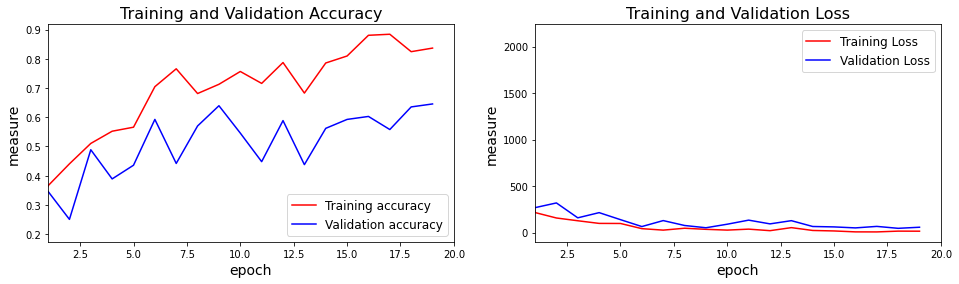

In [0]:
import matplotlib.pyplot as plt
acc = classifier.history['accuracy']
val_acc = classifier.history['val_accuracy']
loss = classifier.history['loss']
val_loss = classifier.history['val_loss']

epochs = range(len(acc))

n_row = 1
n_col = 2
fig, ax = plt.subplots(n_row, n_col, sharex = False, sharey = False, figsize=(16,4))


ax[0].plot(epochs, acc, 'r', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
ax[0].legend(fontsize=12,loc=0)
ax[0].set_title('Training and Validation Accuracy',fontsize=16)
ax[0].set_ylabel('measure',fontsize=14)
ax[0].set_xlabel('epoch', fontsize = 14)
ax[0].set_xlim([1, len(acc)])

ax[1].plot(epochs, loss, 'r', label='Training Loss')
ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
ax[1].legend(fontsize=12)
ax[1].set_title('Training and Validation Loss',fontsize=16)
ax[1].set_ylabel('measure',fontsize=14)
ax[1].set_xlabel('epoch', fontsize = 14)
ax[1].set_xlim([1, len(acc)])


plt.show()

In [0]:
model2.save('/content/drive/My Drive/Estadistica/Estadistica/Mineria de datos/Proyecto Minería de datos/Model_audio_img/NN83.h5')


In [0]:
predictions = model2.predict(X_test)

In [0]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


NameError: ignored

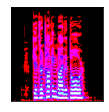

In [0]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 4
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], y_test, X_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()

In [0]:
import os
import numpy as np
import tensorflow as tf
import h5py
import math

def load_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches


def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y


def forward_propagation_for_predict(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters
    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3'] 
                                                           # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     # Z3 = np.dot(W3,Z2) + b3
    
    return Z3

def predict(X, parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    
    x = tf.placeholder("float", [12288, 1])
    
    z3 = forward_propagation_for_predict(x, params)
    p = tf.argmax(z3)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

In [0]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

In [0]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [0]:
# GRADED FUNCTION: convolutional_block

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1,1),padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
   
    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [0]:
# GRADED FUNCTION: ResNet50

def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((2, 2), name='avg_pool')(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [0]:
model = ResNet50(input_shape = (223, 217, 3), classes = 8)

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
y=[int(i)-1 for i in y]
y

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [0]:
from sklearn.model_selection import train_test_split
X_train_orig, X_test_orig,  Y_train_orig, Y_test_orig=  train_test_split(X1, y, test_size=0.2, random_state=42)
X_train_orig=np.array(X_train_orig)
Y_train_orig=np.array(Y_train_orig)
X_test_orig=np.array(X_test_orig)
Y_test_orig=np.array(Y_test_orig)



In [0]:
Y_train_orig.shape

(1961,)

In [0]:
Y_train_orig=Y_train_orig.reshape((1, Y_train_orig.shape[0]))
Y_test_orig=Y_test_orig.reshape((1, Y_test_orig.shape[0]))

In [0]:
classes=np.array(list(set(y))) # the list of classes


In [0]:
# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 8).T
Y_test = convert_to_one_hot(Y_test_orig, 8).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1961
number of test examples = 491
X_train shape: (1961, 223, 217, 3)
Y_train shape: (1961, 8)
X_test shape: (491, 223, 217, 3)
Y_test shape: (491, 8)


In [0]:
classes

array([0, 1, 2, 3, 4, 5, 6, 7])

In [0]:
model.fit(X_train, Y_train, epochs = 10, batch_size = 32)

Epoch 1/10
1961/1961 [==============================] - 1281s 653ms/step - loss: 1.6236 - accuracy: 0.3590
Epoch 2/10
1961/1961 [==============================] - 1288s 657ms/step - loss: 1.3903 - accuracy: 0.4748
Epoch 3/10
1961/1961 [==============================] - 1305s 666ms/step - loss: 1.1530 - accuracy: 0.5584
Epoch 4/10
1961/1961 [==============================] - 1301s 663ms/step - loss: 1.0155 - accuracy: 0.6186
Epoch 5/10
1961/1961 [==============================] - 1296s 661ms/step - loss: 0.7890 - accuracy: 0.7093
Epoch 6/10
1961/1961 [==============================] - 1284s 655ms/step - loss: 0.5812 - accuracy: 0.7853
Epoch 7/10
1961/1961 [==============================] - 1295s 660ms/step - loss: 0.5197 - accuracy: 0.8169
Epoch 8/10
1961/1961 [==============================] - 1305s 665ms/step - loss: 0.3964 - accuracy: 0.8547
Epoch 9/10
1961/1961 [==============================] - 1291s 659ms/step - loss: 0.3215 - accuracy: 0.8822
Epoch 10/10
1961/1961 [==============

In [0]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

491/491 [==============================] - 86s 174ms/step
Loss = 1.379101958148591
Test Accuracy = 0.6537678241729736
